# Part 1: Creating Data Files to Blast
- Parsing results to create create files of concordant, discordant, single match and non match reads 
- Analyze primer matches and spit out numerical data in csv form

In [1]:
## Reads in a folder of data and creates a frequency table for primer pairs that match the reads
## Basic, only for separate reads fastq documents

from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein
import sys
import os
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIXML
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Seq import Seq
import subprocess
import sys
import csv
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

SeqFilePath = '/Users/annechen/Downloads/CRISPR Pools Data/test2'
PrimerID = '/Users/annechen/Downloads/sgRNAs for multiplexed CRISPR - Primer Sequences Only.csv'

output_folder = join(SeqFilePath, 'testout')
## Attempting to put data in separate output_folder
if not os.path.isdir(output_folder): 
    os.mkdir(output_folder)

def primerfreq(SeqFile, start_index):
    
    ############################################################################
    ## Load CSV File of Primer IDs into pandas dataframe
    
    primer = pd.read_csv(PrimerID)
    primer['Frequency'] = 0
    
    ############################################################################
    ## Make a dictionary for sequences
    ## Read in the fastq file  

    SeqDict = {}
    freq = {}

    with open(SeqFile, 'rU') as handle:
        for record in SeqIO.parse(handle, "fastq"):
            SeqDict[str(record.id)] = str(record.seq)
            #ProbeseqList.append(str(record.id)) ## Also make a list of all of the probe sequences for writing the output file.

    ############################################################################
    ##  Make Dictionary by looping through list and count the frequencies

    for record in SeqDict:
        seq = str(SeqDict[record])
        added = False
        newcode = ''
        if seq[-8:] != 'GGGGGGGG':
            for i in freq:
                if i[0:15] == seq[0:15]:
                    freq[i] = freq[i] + 1
                    added = True
                else:
                    newcode = seq[0:15]
            if added == False:
                freq[newcode] = 1

    ############################################################################
    ##  Convert previous dictionary to dataframe 

    fTable = pd.DataFrame.from_dict(freq, orient='index', columns=['Frequency'])
    fTable = fTable.sort_values('Frequency',ascending=False)
    fTable['ID'] = '-'
    
    ############################################################################
    ##  Enter matching primer ID if exists on fTable
    ##  Enter frequency of appearance on primer dataframe

    for seq_index, seq_row in fTable.iterrows():
        for prim_index, prim_row in primer.iterrows():
            primerID = primer.iloc[prim_index,1]
            #print seq_index + ' ' + primerID[start_index+0:start_index+15]
            if seq_index == primerID[start_index:start_index+15]:
                fTable.at[seq_index,'ID'] = primer.iloc[prim_index,0]
                primer.iloc[prim_index,2] = fTable.at[seq_index,'Frequency']
    ##pd.set_option('display.max_rows', 208) ##allows you to view entirety of fTable w/o truncation

    ##print (fTable)
    
    primer = primer.sort_values('Frequency',ascending=False)
    primer = primer.reset_index()
    del primer['index']
    
    ############################################################################
    ##  Export primer frequency data as csv, managing file path
    
    csv_file = join (output_folder, os.path.splitext(os.path.basename(SeqFile))[0] + '_primerMatch.csv')
    
    ##csv_file = join(output_folder, os.path.splitext(SeqFile)[0] + '_primerMatch.csv')

    primer.to_csv(csv_file, sep='\t', index=False)
    primercsv = pd.read_csv('primerMatch.csv',sep='\t')
    #print(primercsv)


for f in listdir(SeqFilePath):
    if not f.startswith('.'):
        ## In R2 file, sequencing left off first base, readjusted index to shift one right
        if '_R2_' in f:
            ##primerfreq(f,1)
            primerfreq(join(SeqFilePath,f),1)
        if '_R1_' in f:
            ##primerfreq(f,0)

            primerfreq(join(SeqFilePath, f),0)

In [15]:
## Code for csv of paired primers from a list of seperate reads

sep_reads = '/Users/annechen/Downloads/CRISPR Pools Data/test'

############################################################################
## Finding matching files in the folder to designate R1 as forward and R2 as reverse

fastq_data = []

for f1 in listdir(sep_reads):
    if '_R1_' in f1 and not f1.startswith('.'):
        forward_f = f1
        for f2 in listdir(sep_reads):
            if '_R2_' in f2 and not f2.startswith('.'):
                if f1.replace('_R1','') == f2.replace('_R2',''):
                    reverse_f = f2
                    
                    ############################################################################
                    ## Creating dataframe with ID, forward, and reverse reads
                    
                    with open (join(sep_reads,f1), 'rU') as forward:
                        for forward_data in SeqIO.parse(forward, 'fastq'):
                            fastq_data.append([str(forward_data.id), str(forward_data.seq)])
                    
                    fastq_df = pd.DataFrame(fastq_data, columns = ['read_ID', 'forward'])
                    index_pos = 0
                    
                    fastq_df['reverse'] = ''
                    with open (join(sep_reads,f2),'rU') as reverse:
                        for reverse_data in SeqIO.parse(reverse, 'fastq'):
                            rev_code = str(reverse_data.seq)
                            ##print fastq_df.at[index_pos, 'read_ID']
                            if str(reverse_data.id) == fastq_df.at[index_pos,'read_ID']:
                                fastq_df.at[index_pos, 'reverse'] = rev_code
                                index_pos += 1
                                
                    ############################################################################            
                    ## Making file name            
                    initial_file_name = os.path.basename(f1.replace('_R1',''))
                    combined_file = join(sep_reads, os.path.splitext(initial_file_name)[0] + '_combined.csv')
                    
                    ##print (initial_file_name)
                    ##print os.path.basename(initial_file_name)
                    ##os.path.splitext(os.path.basename(SeqFile))[0] 
                    ## Making csv file
                    fastq_df.to_csv(combined_file, sep='\t', index=False)
                    ##fastqcsv = pd.read_csv()
                    

1-1_S2_L001_001.fastq
1-1_S2_L001_001.fastq
36_S31_L001_001.fastq
36_S31_L001_001.fastq


In [ ]:
## Working doc that reads in a folder of combined reads and outputs data (only works on one doc at a time)

PrimerID = '/Users/annechen/Downloads/sgRNAs for multiplexed CRISPR - Primer Sequences Only.csv'
combined = '/Users/annechen/Downloads/CRISPR Pools Data/test2/results/1-1_S2_L001_001_combined.csv'
path = '/Users/annechen/Downloads/CRISPR Pools Data/test2/results'


comb_reads = pd.read_csv(combined, sep='\t')
primer = pd.read_csv(PrimerID)
primer.head()

############################################################################
## Create 6 dataframes to hold different information

concordant = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
discordant = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
onematch = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
nomatch = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
freqTable = pd.DataFrame(columns = ['Forward Prim ID', 'Reverse Prim ID', 'Frequency'])
aggData = {}

############################################################################
## Load PrimerID values into freqTable

## Need to change this part of code according to name of primer sequences
for index, row in primer.iterrows():
    if index == 30:
        break
    freqTable = freqTable.append({'Forward Prim ID':primer.iloc[index,0],'Reverse Prim ID':primer.iloc[index+30, 0], 'Frequency':0}, ignore_index=True)
                         
############################################################################
## Iterate through combined list to sort read pairs

for seq_index, seq_row in comb_reads.iterrows():
    
    fseq = comb_reads.iloc[seq_index,1]
    rseq = comb_reads.iloc[seq_index,2]
    
    ##Gfor and Grev = True if there is G-Tail at end of sequence, False if there is no G-tail
    Gfor = fseq[-8:] == 'GGGGGGGG'
    Grev = rseq[-8:] == 'GGGGGGGG'
    ##fID and rID will be changed later if a match is found and there is no G-tail
    fID = 'no forward match'
    rID = 'no reverse match'
    
    ############################################################################
    ## Match each read without a G-tail to a read ID
    
    if not Gfor or not Grev:
        for p_index, p_row in primer.iterrows():
            primerID = primer.iloc[p_index,1]

            if not Gfor and fseq[0:15] == primerID[0:15]:
                fID = primer.iloc[p_index, 0]
            if not Grev and rseq[0:15] == primerID[1:16]:
                rIDcode = primer.iloc[p_index, 0]
                ## Need to change this part of code according to name of primer sequences (manually matches rev code to forward by subtracting 30)
                rID = rIDcode[0:2] + str(int(rIDcode[2:])-30)
    
    
    ############################################################################
    ## Sort read into one of four categories depending on presence of G-Tail and PrimerID Match
    
    if Gfor and Grev:
        nomatch = pd.concat([nomatch, comb_reads.iloc[[seq_index]]])
        
    elif fID == rID:
        ## print 'concordant ' + comb_reads.iloc[seq_index, 0][-4:]
        concordant = pd.concat([concordant, comb_reads.iloc[[seq_index]]])
        
        ## Input info into concordant pair frequency table
        for index, row in freqTable.iterrows():
            if fID == freqTable.iloc[index,0]:
                freqTable.iloc[index,2] += 1
        
    elif fID != 'no forward match' and rID != 'no reverse match':
        ## print 'discordant ' + comb_reads.iloc[seq_index, 0][-4:]
        discordant = pd.concat([discordant, comb_reads.iloc[[seq_index]]])
        
    elif fID != 'no forward match' or rID != 'no reverse match':
        onematch = pd.concat([onematch, comb_reads.iloc[[seq_index]]])
        ## print 'one match ' + comb_reads.iloc[seq_index, 0][-4:]
        
    else:
        nomatch = pd.concat([nomatch, comb_reads.iloc[[seq_index]]])

## Sort freqTable for primer freq from largest to smallest
freqTable = freqTable.sort_values('Frequency', ascending=False)
freqTable = freqTable.reset_index()
del freqTable['index']

############################################################################
## Creating aggregate data dictionary and load into new dataframe

aggData['Concordant'] = len(concordant.index)
aggData['Discordant'] = len(discordant.index)
aggData['One ID Match'] = len(onematch.index)
aggData['No ID Match'] = len(nomatch.index)

aggData_df = pd.DataFrame(aggData.items(), columns=['Pair Type', 'Frequency'])

############################################################################
## Create csv files for each dataframe

concord_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_concordant_file.csv')
concordant.to_csv(concord_csv, sep='\t', index=False)

discord_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_discordant_file.csv')
discordant.to_csv(discord_csv, sep='\t', index=False)

onematch_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_single_match_file.csv')
onematch.to_csv(onematch_csv, sep='\t', index=False)

nomatch_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_no_matches_file.csv')
nomatch.to_csv(nomatch_csv, sep='\t', index=False)

freqTable_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_concordant_freqTable.csv')
freqTable.to_csv(freqTable_csv, sep='\t', index=False)

aggData_df_csv = join(path, os.path.splitext(os.path.basename(combined))[0] + '_aggregate_data.csv')
aggData_df.to_csv(aggData_df_csv, sep='\t', index=False)


In [10]:
## Reads in a folder of seperate fastq reads
## Creates output of combined reads from fastq files and 6 docs of data:
## 6 docs: list of concordant, discordant, single match, and no match reads, a frequency table of concordant reads, and an aggregate table of the number of reads of each type

from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein
import sys
import os
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIXML
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Seq import Seq
import subprocess
import sys
import csv
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

sep_reads = '/Users/annechen/Downloads/CRISPR Pools Data/test2'
PrimerID = '/Users/annechen/Downloads/sgRNAs for multiplexed CRISPR - Primer Sequences Only.csv'

############################################################################
## Creating output folder to put results in

output_folder = join(sep_reads, 'results')
## Put data in separate output_folder
if not os.path.isdir(output_folder): 
    os.mkdir(output_folder)
    
############################################################################
## Create function to analyze combined reads csv file and split data into the 6 docs
                    
def pairAnalyze(CombSeqFile, PrimerIDFile):
    
    comb_reads = pd.read_csv(CombSeqFile, sep='\t')
    primer = pd.read_csv(PrimerIDFile)
    
    ############################################################################
    ## Create 6 dataframes to hold different information

    concordant = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
    discordant = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
    onematch = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
    nomatch = pd.DataFrame(columns = ['read_ID', 'forward', 'reverse'])
    freqTable = pd.DataFrame(columns = ['Forward Prim ID', 'Reverse Prim ID', 'Frequency'])
    aggData = {}
    
    ############################################################################
    ## Load PrimerID values into freqTable

    ## Need to change this part of code according to name of primer sequences
    for index, row in primer.iterrows():
        if index == 30:
            break
        freqTable = freqTable.append({'Forward Prim ID':primer.iloc[index,0],'Reverse Prim ID':primer.iloc[index+30, 0], 'Frequency':0}, ignore_index=True)

    ############################################################################
    ## Iterate through combined list to sort read pairs

    for seq_index, seq_row in comb_reads.iterrows():

        fseq = comb_reads.iloc[seq_index,1]
        rseq = comb_reads.iloc[seq_index,2]

        ##Gfor and Grev = True if there is G-Tail at end of sequence, False if there is no G-tail
        Gfor = fseq[-8:] == 'GGGGGGGG'
        Grev = rseq[-8:] == 'GGGGGGGG'
        ##fID and rID will be changed later if a match is found and there is no G-tail
        fID = 'no forward match'
        rID = 'no reverse match'
        
        ############################################################################
        ## Match each read without a G-tail to a read ID

        if not Gfor or not Grev:
            for p_index, p_row in primer.iterrows():
                primerID = primer.iloc[p_index,1]

                if not Gfor and fseq[0:15] == primerID[0:15]:
                    fID = primer.iloc[p_index, 0]
                if not Grev and rseq[0:15] == primerID[1:16]:
                    rIDcode = primer.iloc[p_index, 0]
                    ## Need to change this part of code according to name of primer sequences (manually matches rev code to forward by subtracting 30)
                    rID = rIDcode[0:2] + str(int(rIDcode[2:])-30)

        ############################################################################
        ## Sort read into one of four categories depending on presence of G-Tail and PrimerID Match

        if Gfor and Grev:
            nomatch = pd.concat([nomatch, comb_reads.iloc[[seq_index]]])

        elif fID == rID:
            ## print 'concordant ' + comb_reads.iloc[seq_index, 0][-4:]
            concordant = pd.concat([concordant, comb_reads.iloc[[seq_index]]])

            ## Input info into concordant pair frequency table
            for index, row in freqTable.iterrows():
                if fID == freqTable.iloc[index,0]:
                    freqTable.iloc[index,2] += 1
                
        elif fID != 'no forward match' and rID != 'no reverse match':
            ## print 'discordant ' + comb_reads.iloc[seq_index, 0][-4:]
            discordant = pd.concat([discordant, comb_reads.iloc[[seq_index]]])

        elif fID != 'no forward match' or rID != 'no reverse match':
            onematch = pd.concat([onematch, comb_reads.iloc[[seq_index]]])
            ## print 'one match ' + comb_reads.iloc[seq_index, 0][-4:]

        else:
            nomatch = pd.concat([nomatch, comb_reads.iloc[[seq_index]]])

    ## Sort freqTable for primer freq from largest to smallest
    freqTable = freqTable.sort_values('Frequency', ascending=False)
    freqTable = freqTable.reset_index()
    del freqTable['index']

    ############################################################################
    ## Creating aggregate data dictionary and load into new dataframe

    aggData['Concordant'] = len(concordant.index)
    aggData['Discordant'] = len(discordant.index)
    aggData['One ID Match'] = len(onematch.index)
    aggData['No ID Match'] = len(nomatch.index)

    aggData_df = pd.DataFrame(aggData.items(), columns=['Pair Type', 'Frequency'])

    ############################################################################
    ## Create csv files for each dataframe

    concord_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_concordant_file.csv')
    concordant.to_csv(concord_csv, sep='\t', index=False)

    discord_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_discordant_file.csv')
    discordant.to_csv(discord_csv, sep='\t', index=False)

    onematch_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_single_match_file.csv')
    onematch.to_csv(onematch_csv, sep='\t', index=False)

    nomatch_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_no_matches_file.csv')
    nomatch.to_csv(nomatch_csv, sep='\t', index=False)

    freqTable_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_concordant_freqTable.csv')
    freqTable.to_csv(freqTable_csv, sep='\t', index=False)

    aggData_df_csv = join(os.path.dirname(CombSeqFile), os.path.splitext(os.path.basename(CombSeqFile))[0] + '_aggregate_data.csv')
    aggData_df.to_csv(aggData_df_csv, sep='\t', index=False)

############################################################################
## Fill results folder with combined reads pooling paired separate reads together

for f1 in listdir(sep_reads):
    if '_R1_' in f1 and not f1.startswith('.'):
        forward_f = f1
        for f2 in listdir(sep_reads):
            if '_R2_' in f2 and not f2.startswith('.'):
                if f1.replace('_R1','') == f2.replace('_R2',''):
                    
                    fastq_data = []
                    reverse_f = f2
                    
                    ############################################################################
                    ## Creating dataframe with ID, forward, and reverse reads
                    
                    with open (join(sep_reads,f1), 'rU') as forward:
                        for forward_data in SeqIO.parse(forward, 'fastq'):
                            fastq_data.append([str(forward_data.id), str(forward_data.seq)])
                    
                    fastq_df = pd.DataFrame(fastq_data, columns = ['read_ID', 'forward'])
                    index_pos = 0
                    
                    fastq_df['reverse'] = ''
                    with open (join(sep_reads,f2),'rU') as reverse:
                        for reverse_data in SeqIO.parse(reverse, 'fastq'):
                            rev_code = str(reverse_data.seq)
                            ##print fastq_df.at[index_pos, 'read_ID']
                            if str(reverse_data.id) == fastq_df.at[index_pos,'read_ID']:
                                fastq_df.at[index_pos, 'reverse'] = rev_code
                                index_pos += 1
                                
                    ############################################################################            
                    ## Making file name            
                    initial_file_name = os.path.basename(f1.replace('_R1',''))
                    combined_file = join(output_folder, os.path.splitext(initial_file_name)[0] + '_combined.csv')
                    
                    ## Making csv file
                    fastq_df.to_csv(combined_file, sep='\t', index=False)

## Load CSV File of Primer IDs into pandas dataframe
##primer = pd.read_csv(PrimerID)

for f in listdir(output_folder):
    if not f.startswith('.'):
        pairAnalyze(join(output_folder, f), PrimerID)
    
    
    

In [ ]:
## Makes a csv containing all the data necessary to graph the results
## Requires a folder of all data files generated from previous cell

%matplotlib inline

import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib

data = '/Users/annechen/Downloads/CRISPR Pools Data/results'
PrimerID = '/Users/annechen/Downloads/sgRNAs for multiplexed CRISPR - Primer Sequences Only.csv'

primer = pd.read_csv(PrimerID)
graph_data = pd.DataFrame(columns = ['Sample ID', 'Total Reads', 'Discordant', 'Single match', 'No match', 'Concordant'])
avg_rep = pd.DataFrame(columns = ['Forward ID', 'Reverse ID', 'Forward Sequence', 'Reverse Sequence', '% Frequency'])

############################################################################
## Input info from primer doc into final aggregate dataframes

for index, row in primer.iterrows():
    if index < 30:
        primerID = primer.iloc[index,1]
        pairs = primer.iloc[index,0] + ', ' + primer.iloc[index+30,0]
        graph_data[pairs] = 0
            
        avg_rep = avg_rep.append({'Forward ID':primer.iloc[index,0],'Reverse ID':primer.iloc[index+30,0], 
                                  'Forward Sequence':primer.iloc[index,1], 'Reverse Sequence':primer.iloc[index+30,1]}, 
                                 ignore_index=True)


for f in listdir(data):
    
    if '_aggregate_data.csv' in f:
        agg_data = pd.read_csv(join(data, f), sep='\t')
        sample_name = f.split('_')[0]
        total = agg_data.iloc[0,1] + agg_data.iloc[1,1] + agg_data.iloc[2,1] + agg_data.iloc[3,1]
        graph_data = graph_data.append({'Sample ID':sample_name, 'Total Reads':total, 'Discordant':agg_data.iloc[3,1],
                                       'Single match':agg_data.iloc[0,1],'No match':agg_data.iloc[2,1],
                                       'Concordant':agg_data.iloc[1,1]}, ignore_index=True)

for f in listdir(data): 
    
    if '_concordant_freqTable.csv' in f:
        freq = pd.read_csv(join(data,f), sep='\t')
        sample_name = f.split('_')[0]
        for index, row in graph_data.iterrows():
            if graph_data.iloc[index,0] == sample_name:
                for f_index, f_row in freq.iterrows():
                    primerpair =  freq.iloc[f_index,0] + ', ' + freq.iloc[f_index, 1]
                    graph_data.loc[index, primerpair] = freq.iloc[f_index, 2]        

## Optional: Add total columns to calculate primer totals to graph_data df for column and row 
## (if you only uncomment this part w/o modification, will mess up total values for calculating avg_rep)

##graph_data.loc['Column Total'] = graph_data.sum(numeric_only=True, axis = 0, skipna = True) 
##graph_data.loc[:,'Primer Count Total'] = graph_data.sum(numeric_only=True, axis = 1, skipna = True)

############################################################################
## Calculate frequency for average primer representation dataframe based on first 20 std cond experiments

std_cond = graph_data.head(20).copy()

std_cond.loc['Total'] = std_cond.sum(numeric_only=True, axis = 0, skipna = True) 
std_cond.loc[:,'Primer Count Total'] = std_cond.sum(numeric_only=True, axis = 1, skipna = True)

totalcount = std_cond.iloc[len(std_cond)-1, len(std_cond.columns)-1]

counter = 0
for i in range(6, len(std_cond.columns)-1):
    occurence = std_cond.iloc[len(std_cond)-1,i]
    frequency = (occurence/totalcount)*100
    avg_rep.iloc[counter, 4] = round(frequency, 3)
    counter += 1

############################################################################
## Load both dataframes into csv files

graph_data_csv = join(data, 'graphable_data.csv')
graph_data.to_csv(graph_data_csv, sep='\t', index=False)

avg_rep_csv = join(data, 'avg_primer_representation.csv')
avg_rep.to_csv(avg_rep_csv, sep='\t', index=False)



# Part 2: Using BLAST to create custom db of primers
- Run local blast on primers against dmel genome and generate locations
- Create a fasta file to convert to custom db

## Testing: Using online blast to generate custom db

Everything below this is me trying to figure out how to use BLAST through Biopython through online BLAST

In [68]:
## Test to try to blast a sequence over internet

from Bio.Blast import NCBIWWW
from Bio import SeqIO

result_handle = NCBIWWW.qblast("blastn","nt", "CTGGGACCCGACAGTTGTCAT")
with open("my_blast.xml", "w") as out_handle:
    out_handle.write(result_handle.read())
    
result_handle.close()
result_handle = open("my_blast.xml")

from Bio.Blast import NCBIXML

blast_record = NCBIXML.read(result_handle)

E_VALUE_THRESH = 0.5

for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        if hsp.expect < E_VALUE_THRESH:
            print("sequence:", alignment.title)
            print("length:", alignment.length)
            print("e value:", hsp.expect)
            print(hsp.query[0:75] + "...")
            print(hsp.match[0:75] + "...")
            print(hsp.sbjct[0:75] + "...")

Note: tested the commands through terminal
<br>** In order to run short sequences of alignment, have to use -word_size 7 or else the code will say there are no alignments even when there are
<br>** Making a blast database (Makeblastdb) is easiest done through terminal, but actual local blast can be through jupyter notebook

In [192]:
## Test to make a database from a downloaded genome off flybase

from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast import NCBIXML

file = '/Users/annechen/Downloads/dmel-all-chromosome-r5.49.fasta'

## Command Line args for local blast

## makeblastdb -in dmel-all-chromosome-r5.49.fasta -dbtype nucl
## blastn -query testprimerf.fasta -db dmel-all-chromosome-r5.49.fasta -evalue 0.1 -word_size 7

blastx_cline = NcbiblastxCommandline(cmd='blastn', query='PCRProject/query.fasta', db='PCRProject/dmel-all-chromosome-r5.49.fasta', evalue=0.1, out='PCRProject/TestBlast.xml', outfmt=5, word_size=7)

blastx_cline()




('', '')

In [37]:
## Make a fasta file of all primers given a avg_rep.csv (generated from cell 5)

import pandas as pd
import numpy as np

avg_rep_file = '/Users/annechen/Downloads/CRISPR Pools Data/results/avg_primer_representation.csv'

avg_rep = pd.read_csv(avg_rep_file, sep = '\t')

primerf = open("PCRProject/primerf.fasta", 'w')
for index, row in avg_rep.iterrows():
    primerf.write('>'+avg_rep.iloc[index,0]+' row='+str(index)+'\n'+avg_rep.iloc[index,2]+'\n')
    primerf.write('>'+avg_rep.iloc[index,1]+' row='+str(index)+'\n'+avg_rep.iloc[index,3]+'\n')

primerf.close()

In [27]:
## BLAST Fasta file

##In terminal: to make db from fasta
##makeblastdb -in dmel-all-chromosome-r5.49.fasta -dbtype nucl


from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast import NCBIXML

primerf = 'PCRProject/primerf.fasta'
dmeldb = 'PCRProject/dmel-all-aligned-r5.49.fasta'

blastx_cline = NcbiblastxCommandline(cmd='blastn', query=primerf, db=dmeldb, evalue=0.5, out='PCRProject/TestBlast.xml', outfmt=5)

blastx_cline()


('', '')

In [135]:
## Create a df of the blast xml results file
## This cell ends up not being used (use below cell to create a dictionary instead)

from Bio.Blast import NCBIXML

avg_rep_file = '/Users/annechen/Downloads/CRISPR Pools Data/results/avg_primer_representation.csv'
blastdf = pd.DataFrame(columns = ['primerID', 'rowID', 'hitID','locStart','locEnd'])

result_handle = open("PCRProject/9T6PZX5C016-Alignment.xml")
##result_handle = open("PCRProject/Test.xml")

blast_records = NCBIXML.parse(result_handle)

for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            if hsp.expect< 0.02:
                ID = blast_record.query
                blastdf = blastdf.append({'primerID':ID.split('r')[0],'rowID':ID.split('=')[1],'hitID':alignment.hit_id,
                                         'locStart':hsp.sbjct_start, 'locEnd':hsp.sbjct_end}, ignore_index=True)
                break

                
blastdf.head()

                
                
                

,primerID,rowID,hitID,locStart,locEnd
0,JH441,0,gi|669632474|ref|NC_004354.4|,759135,759155
1,JH471,0,gi|669632474|ref|NC_004354.4|,759384,759362
2,JH442,1,gi|669632474|ref|NC_004354.4|,764953,764975
3,JH472,1,gi|669632474|ref|NC_004354.4|,765211,765192
4,JH443,2,gi|669632474|ref|NC_004354.4|,796293,796318


In [147]:
## Create a nested dict of data in the blast xml results file 
## Basically does same thing as above cell but through a different method to make easier data retrieval

from Bio.Blast import NCBIXML

avg_rep_file = '/Users/annechen/Downloads/CRISPR Pools Data/results/avg_primer_representation.csv'
blastdf = pd.DataFrame(columns = ['primerID', 'rowID', 'hitID','locStart','locEnd'])
blast_result_dict = {}

result_handle = open("PCRProject/9T6PZX5C016-Alignment.xml")
##result_handle = open("PCRProject/Test.xml")

## Create initial nested dict of data from blast xml file

blast_records = NCBIXML.parse(result_handle)
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            if hsp.expect< 0.02:
                ID = blast_record.query
                hitId = alignment.hit_id
                rowId = ID.split('=')[1]
                rowRec = blast_result_dict.get(rowId) 
                if rowRec == None:
                    rowRec = {}
                    blast_result_dict[rowId] = rowRec
                hitList = rowRec.get(hitId)
                if hitList == None:
                    hitList = []
                    rowRec[hitId] = hitList
                hitEntry = {}
                hitEntry['primerID'] =  ID.split('r')[0]
                hitEntry['start'] = hsp.sbjct_start
                hitEntry['end'] = hsp.sbjct_end
                hitList.append (hitEntry)

                break

                
## Loop through dictionary to throw out chromosome repeats: isolate matching primer sequences

for row_num in blast_result_dict:
    hits = blast_result_dict[row_num]
    tobedeleted= []
    for locdict in hits:
        hitList = hits[locdict]
        if len(hitList) != 2:
            tobedeleted.append(locdict)
    for i in tobedeleted:
        del hits[i]

## blast_result_dict holds a nested dictionary of all the information
##print blast_result_dict

{u'24': {u'gi|669632474|ref|NC_004354.4|': [{'start': 1922815, 'end': 1922834, 'primerID': u'JH465'}, {'start': 1923088, 'end': 1923068, 'primerID': u'JH495'}]}, u'25': {u'gi|669632474|ref|NC_004354.4|': [{'start': 2041719, 'end': 2041740, 'primerID': u'JH466'}, {'start': 2041983, 'end': 2041964, 'primerID': u'JH496'}]}, u'26': {u'gi|669632474|ref|NC_004354.4|': [{'start': 2080418, 'end': 2080437, 'primerID': u'JH467'}, {'start': 2080716, 'end': 2080696, 'primerID': u'JH497'}]}, u'27': {u'gi|669632474|ref|NC_004354.4|': [{'start': 2270729, 'end': 2270749, 'primerID': u'JH468'}, {'start': 2271027, 'end': 2271008, 'primerID': u'JH498'}]}, u'20': {u'gi|669632474|ref|NC_004354.4|': [{'start': 1669560, 'end': 1669583, 'primerID': u'JH461'}, {'start': 1669894, 'end': 1669874, 'primerID': u'JH491'}]}, u'21': {u'gi|669632474|ref|NC_004354.4|': [{'start': 1695701, 'end': 1695722, 'primerID': u'JH462'}, {'start': 1696003, 'end': 1695980, 'primerID': u'JH492'}]}, u'22': {u'gi|669632474|ref|NC_004

In [173]:
import re

blastdbfinal = pd.DataFrame(columns = ['forPrimerID', 'revPrimerID', 'hitID', 'rowID', 'locStart','locEnd'])

##min = 9999999999
##max = 0
count = 0
for row_num in blast_result_dict:
    hits = blast_result_dict[row_num]
    for locdict in hits:
        min = 9999999999
        max = 0
        hitList = hits[locdict]
        p1 = hitList[0]['primerID']
        p2= hitList[1]['primerID']
        
        m = re.search('ref\|(.*)\..+\|',locdict)
        refseqid = m.group(1)
        blastdbfinal = blastdbfinal.append({'rowID':int(row_num),'hitID':refseqid, 'forPrimerID':p1,
                                    'revPrimerID':p2}, ignore_index=True)

        for read in hitList:
            #read = hitList[i]
            if read['start']<min:
                min = read['start']
            if read['start']>max:
                max = read['start']
            if read['end']<min:
                min = read['end']
            if read['end']>max:
                max = read['end']
        blastdbfinal.iloc[count,4]=min
        blastdbfinal.iloc[count,5]=max
        count += 1

blastdbfinal = blastdbfinal.sort_values('rowID', ascending=True)
blastdbfinal = blastdbfinal.reset_index()
del blastdbfinal['index']

blastdbfinal



,forPrimerID,revPrimerID,hitID,rowID,locStart,locEnd
0,JH441,JH471,NC_004354,0,759135,759384
1,JH442,JH472,NC_004354,1,764953,765211
2,JH443,JH473,NC_004354,2,796293,796587
3,JH444,JH474,NC_004354,3,801264,801530
4,JH445,JH475,NC_004354,4,805929,806216
5,JH446,JH476,NC_004354,5,934882,935163
6,JH447,JH477,NC_004354,6,940706,940955
7,JH448,JH478,NC_004354,7,1209740,1210016
8,JH449,JH479,NC_004354,8,1236325,1236574
9,JH450,JH480,NC_004354,9,1286307,1286558


In [190]:
## Takes in a downloaded file of dmel chromosome data and creates an output fasta file of the custom db
## This was a test cell that ISN'T ULTIMATELY USED: the dmel file I downloaded didn't align quite right
    ## with the code --> had to instead download the individual chromosome file off ncbi blast website

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIXML
import csv
import pandas as pd
import numpy as np
import re
from sets import Set

dmelfasta = 'PCRProject/dmel-all-chromosome-r5.49.fasta'

uniqueRefSeqIds = Set()
for index, row in blastdbfinal.iterrows():
    uniqueRefSeqIds.add(blastdbfinal.iloc[index,2])
    
print uniqueRefSeqIds

fastaSeq = {}


with open(dmelfasta, 'rU') as handle:
    for record in SeqIO.parse(handle, "fasta"):
       ## print record.description
        m = re.search('(REFSEQ\:(.*)\,GB:\S+);',record.description)
        if m:
            ids= m.group(1)
            refSeqID = m.group(2)
            ##print refSeqID
            ##print ids
            if refSeqID in uniqueRefSeqIds:
                fastaInfo = {}
                fastaInfo['id'] = record.id
                fastaInfo['dbxref'] = ids
                fastaInfo['seq'] = str(record.seq)
                fastaSeq[refSeqID] = fastaInfo

##print fastaSeq
f = open('PCRProject/customdb2.fasta', 'w')
for index, row in blastdbfinal.iterrows():
    working = fastaSeq[blastdbfinal.iloc[index,2]]
    start = blastdbfinal.iloc[index,4]
    end = blastdbfinal.iloc[index,5]
    f.write('>'+working['id']+' loc='+str(start)+'..'+str(end)+' dbxref='+working['dbxref']+' fwdPrimer='
            +blastdbfinal.iloc[index,0]+' revPrimer='+blastdbfinal.iloc[index,1]+'\n')
    f.write(working['seq'][start-1: end-1]+'\n')
f.close()
    


Set([u'NC_004354'])


In [191]:
## Takes in a fasta file (downloaded directly off NCBI as a separate file for each chromosome)
## Creates custom db in fasta format

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIXML
import csv
import pandas as pd
import numpy as np
import re
from sets import Set

dmelchromfasta = 'PCRProject/sequence.fasta'

## Create set of seqref IDs (catalogues chromosome number)
## Based on results of set, download corresponding chromosome numbers of NCBI website

uniqueRefSeqIds = Set()
for index, row in blastdbfinal.iterrows():
    uniqueRefSeqIds.add(blastdbfinal.iloc[index,2])
    
print uniqueRefSeqIds

## Parses downloaded fasta file of chromosome and pulls out relevant info to put in dictionary

fastaSeq = {}

with open(dmelchromfasta, 'rU') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        m = re.search('(.*)\..+',str(record.id))
        refSeqID = m.group(1)
        if refSeqID in uniqueRefSeqIds:
            fastaInfo = {}
            fastaInfo['id'] = refSeqID
            fastaInfo['header'] = record.description
            fastaInfo['seq'] = str(record.seq)
            fastaSeq[refSeqID] = fastaInfo
        ##print record.id
        ##print record.description

## Creates a new fasta file to write in the custom db and save it        

f = open('PCRProject/customdb.fasta', 'w')
for index, row in blastdbfinal.iterrows():
    working = fastaSeq[blastdbfinal.iloc[index,2]]
    start = blastdbfinal.iloc[index,4]
    end = blastdbfinal.iloc[index,5]
    f.write('>'+working['header']+' loc='+str(start)+'..'+str(end)+' fwdPrimer='
            +blastdbfinal.iloc[index,0]+' revPrimer='+blastdbfinal.iloc[index,1]+'\n')
    f.write(working['seq'][start-1: end]+'\n')
f.close()

Set([u'NC_004354'])


## Final: Put Everything Above Together and Use Local Blast!
Basically modified code to use local blast after I figured out the word_size thing (without it my code wasn't working so I did everything with online blast)

In [ ]:
#################################################################################3
## Make a fasta file called primerf.fasta for all the primers to run through local blast

import pandas as pd
import numpy as np

avg_rep_file = '/Users/annechen/Downloads/CRISPR Pools Data/results/avg_primer_representation.csv'

avg_rep = pd.read_csv(avg_rep_file, sep = '\t')

primerf = open("PCRProject/primerf.fasta", 'w')
for index, row in avg_rep.iterrows():
    primerf.write('>'+avg_rep.iloc[index,0]+' row='+str(index)+'\n'+avg_rep.iloc[index,2]+'\n')
    primerf.write('>'+avg_rep.iloc[index,1]+' row='+str(index)+'\n'+avg_rep.iloc[index,3]+'\n')

primerf.close()

### Run local blast against primerf.fasta

In [195]:
## Create a db from an input dmel genome file

from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast import NCBIXML

file = 'PCRProject/dmel-all-chromosome-r5.49.fasta'

#################################################################################
## First use linux for creating db from dmel genome I downloaded off flybase

## makeblastdb -in dmel-all-chromosome-r5.49.fasta -dbtype nucl

#################################################################################
## Run a local blast and output an xml file to parse the results and primer location

## Can be done either through terminal: 
## blastn -query testprimerf.fasta -db dmel-all-chromosome-r5.49.fasta -evalue 0.1 -word_size 7

## or through jupyter notebook:
blastx_cline = NcbiblastxCommandline(cmd='blastn', query='PCRProject/primerf.fasta', db='PCRProject/dmel-all-chromosome-r5.49.fasta', 
                                     evalue=0.1, out='PCRProject/BlastResults.xml', outfmt=5, word_size=7)

blastx_cline()

('', '')

### Parse Local Blast XML File Results 
First cell: Input Blast Results XML File data into a nested dictionary. Throw out any reads on different chromosomes that do not match
<br>Second cell: Determines start and end locations of each primer and inputs final data into a dataframe (blastdbfinal)

In [204]:
## Create a nested dict of data in the blast xml results file 

from Bio.Blast import NCBIXML

blastdf = pd.DataFrame(columns = ['primerID', 'rowID', 'hitID','locStart','locEnd'])
blast_result_dict = {}

result_handle = open("PCRProject/BlastResults.xml")

#################################################################################
## Create initial nested dict of data from blast xml file

blast_records = NCBIXML.parse(result_handle)
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            if hsp.expect< 0.02:
                ID = blast_record.query
                m = re.search('REFSEQ\:(.*)\,GB:\S+;',alignment.hit_def)
                hitId = m.group(1)
                rowId = ID.split('=')[1]
                rowRec = blast_result_dict.get(rowId) 
                if rowRec == None:
                    rowRec = {}
                    blast_result_dict[rowId] = rowRec
                hitList = rowRec.get(hitId)
                if hitList == None:
                    hitList = []
                    rowRec[hitId] = hitList
                hitEntry = {}
                hitEntry['primerID'] =  ID.split('r')[0]
                hitEntry['start'] = hsp.sbjct_start
                hitEntry['end'] = hsp.sbjct_end
                hitList.append (hitEntry)

                break

                
## Loop through dictionary to throw out chromosome repeats: isolate matching primer sequences

for row_num in blast_result_dict:
    hits = blast_result_dict[row_num]
    tobedeleted= []
    for locdict in hits:
        hitList = hits[locdict]
        if len(hitList) != 2:
            tobedeleted.append(locdict)
    for i in tobedeleted:
        del hits[i]

## blast_result_dict holds a nested dictionary of all the information
## print blast_result_dict

In [205]:
## Takes in nested dictionary from previous cell and converts it to a readable dataframe
import re

blastdbfinal = pd.DataFrame(columns = ['forPrimerID', 'revPrimerID', 'hitID', 'rowID', 'locStart','locEnd'])

##min = 9999999999
##max = 0
count = 0
for row_num in blast_result_dict:
    hits = blast_result_dict[row_num]
    for locdict in hits:
        min = 9999999999
        max = 0
        hitList = hits[locdict]
        p1 = hitList[0]['primerID']
        p2= hitList[1]['primerID']
        blastdbfinal = blastdbfinal.append({'rowID':int(row_num),'hitID':refseqid, 'forPrimerID':p1,
                                    'revPrimerID':p2}, ignore_index=True)
        for read in hitList:
            #read = hitList[i]
            if read['start']<min:
                min = read['start']
            if read['start']>max:
                max = read['start']
            if read['end']<min:
                min = read['end']
            if read['end']>max:
                max = read['end']
        blastdbfinal.iloc[count,4]=min
        blastdbfinal.iloc[count,5]=max
        count += 1

blastdbfinal = blastdbfinal.sort_values('rowID', ascending=True)
blastdbfinal = blastdbfinal.reset_index()
del blastdbfinal['index']

## blastdbfinal


,forPrimerID,revPrimerID,hitID,rowID,locStart,locEnd
0,JH441,JH471,NC_004354,0,653168,653417
1,JH442,JH472,NC_004354,1,658986,659244
2,JH443,JH473,NC_004354,2,690326,690620
3,JH444,JH474,NC_004354,3,695297,695563
4,JH445,JH475,NC_004354,4,699962,700249
5,JH446,JH476,NC_004354,5,828915,829196
6,JH447,JH477,NC_004354,6,834739,834988
7,JH448,JH478,NC_004354,7,1103773,1104049
8,JH449,JH479,NC_004354,8,1130358,1130607
9,JH450,JH480,NC_004354,9,1180340,1180591


### Matches XML file results to create custom fasta db
Don't forget to use terminal to convert fasta to db at very end

In [210]:
## Takes in a downloaded file of dmel chromosome data and creates an output fasta file of the custom db

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIXML
import csv
import pandas as pd
import numpy as np
import re
from sets import Set

dmelfasta = 'PCRProject/dmel-all-chromosome-r5.49.fasta'

uniqueRefSeqIds = Set()
for index, row in blastdbfinal.iterrows():
    uniqueRefSeqIds.add(blastdbfinal.iloc[index,2])
    
fastaSeq = {}


with open(dmelfasta, 'rU') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        m = re.search('(REFSEQ\:(.*)\,GB:\S+);',record.description)
        if m:
            ids= m.group(1)
            refSeqID = m.group(2)
            if refSeqID in uniqueRefSeqIds:
                fastaInfo = {}
                fastaInfo['id'] = record.id
                fastaInfo['dbxref'] = ids
                fastaInfo['seq'] = str(record.seq)
                fastaSeq[refSeqID] = fastaInfo

##print fastaSeq
f = open('PCRProject/customdb2.fasta', 'w')
for index, row in blastdbfinal.iterrows():
    working = fastaSeq[blastdbfinal.iloc[index,2]]
    start = blastdbfinal.iloc[index,4]
    end = blastdbfinal.iloc[index,5]
    f.write('>'+working['id']+'_'+str(index)+' loc='+str(start)+'..'+str(end)+' dbxref='+working['dbxref']+' fwdPrimer='
            +blastdbfinal.iloc[index,0]+' revPrimer='+blastdbfinal.iloc[index,1]+'\n')
    f.write(working['seq'][start-1: end]+'\n')
f.close()
    
## After creating file, use terminal to convert to db:
## makeblastdb -in customdb2.fasta -dbtype nucl

# Part 3: Blast data (from Part 1) and create amplicon alignment

### Create Fasta files of unique separate reads
- Load values into dictionary and throw out repeats
- Outputs a forward and reverse fasta file in a new "amplicons" folder within the folder of the concordant files
- Fasta file headers in format ID_Frequency_Chromosome (as it appears in the db) (Ex: 12_2511_X_10)

In [49]:
import csv
import pandas as pd
import os
from os import listdir
from os.path import join
from Bio import SeqIO

## folder containing _combined_concordant_files generated from part 1
conc_read_folder = '/Users/annechen/Downloads/CRISPR_Pools_Data/results'
db = 'PCRProject/customdb2.fasta'

def uniqueFasta(conc_file, db_dict):
    
    unique = pd.DataFrame(columns = ['count', 'forward', 'reverse', 'locus'])

    ## key will be the unique sequence, value is the count
    result = {}

    conc_read = pd.read_csv(conc_file, sep='\t')
    conc_read.head()

    ## Throw out repeat sequences by adding new sequences into dictionary
    changed = False
    for c_index, c_row in conc_read.iterrows():
        str_key = conc_read.iloc[c_index,1] + ',' + conc_read.iloc[c_index, 2]
        current_count = result.get(str_key)
        if ( current_count):
            result[str_key] = current_count+1
        else:
            result[str_key] = 1    
    
    ## Load unique final values into dataframe to sort and write into fasta file
    for key in result:
        (forward,backward)=key.split(',')
        locus = db_dict.get(str(forward)[0:15])
        unique = unique.append({'count':result[key],'forward':forward,'reverse':backward, 'locus':locus}, ignore_index=True)

    unique = unique.sort_values('count', ascending = False)
    unique = unique.reset_index()
    del unique['index']

    ## Sort dataframe
    unique = unique.sort_values('count', ascending = False)
    unique = unique.reset_index()
    del unique['index']

    ## Create fasta file to blast
    file_name = os.path.basename(conc_file)
    exp_id = file_name.split('_combined')[0]
    path = join(os.path.dirname(conc_file),'align')
    
    ## Gives header of fasta in format number_frequency_chromosome
    fwd = open(join(path, exp_id+'fwd.fasta'),'w')
    rev = open(join(path, exp_id+'rev.fasta'),'w')
    for index, row in unique.iterrows():
        fwd.write('>'+str(index)+'_'+str(unique.iloc[index,0])+'_'+str(unique.iloc[index,3])+'\n'+unique.iloc[index,1]+'\n')
        rev.write('>'+str(index)+'_'+str(unique.iloc[index,0])+'_'+str(unique.iloc[index,3])+'\n'+unique.iloc[index,2]+'\n')
    fwd.close()
    rev.close()
    
## Generate dictionary of first 15 characters of each locus to match primer from the db file
db_seq = {}
with open(db, 'rU') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        db_seq[str(record.seq)[0:15]] = str(record.id)

output_folder = join(conc_read_folder, 'align')
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
for f in listdir(conc_read_folder):
    if 'combined_concordant_file' in f:
        uniqueFasta(join(conc_read_folder, f), db_seq)
        


### Constructing the Amplicon Alignments
- Using the read-linker file here: https://github.com/weizhongli/cdhit/wiki/3.-User's-Guide#readlinker
- Goes through and creates amplicon folder of reads

In [32]:
import os
from os import listdir
from os.path import join

alignments = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/align'
##read-linker = '/Users/annechen/Downloads/read-linker.pl'

for f1 in listdir(alignments):
    if 'fwd.fasta' in f1:
        fwd = join(alignments, f1)
        rev = fwd.replace('fwd', 'rev')
        output = join(alignments, f1.replace("fwd", "_amplicons"))
        ##! perl /Users/annechen/Downloads/read-linker.pl -i /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001fwd.fasta -j /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001rev.fasta  -o /Users/annechen/Downloads/into.fa -p 12 -s 4
        ##print ("f = " + fwd)
        ##print ("r = " + rev)
        ##print ("output to file: " + output)
        cmdstr = "perl /Users/annechen/Downloads/read-linker.pl -i " + fwd + " -j " + rev + " -o " + output +  " -p 12 -s 4"
        ##print (" cmd:" + cmdstr)
        os.system(cmdstr)
                
        ##! /miniconda2/bin/perl /Users/annechen/Downloads/read-linker.pl -i fwd -j rev -o output -p 12 -s 4

 

f = /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001fwd.fasta
r = /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001rev.fasta
output to file: /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001_amplicons.fasta
 cmd:perl /Users/annechen/Downloads/read-linker.pl -i /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001fwd.fasta -j /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001rev.fasta -o /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-1_S2_L001_001_amplicons.fasta -p 12 -s 4
f = /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-2_S3_L001_001fwd.fasta
r = /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-2_S3_L001_001rev.fasta
output to file: /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1-2_S3_L001_001_amplicons.fasta
 cmd:perl /Users/annechen/Downloads/read-linker.pl -i /Users/annechen/Downloads/CRISPR_Pools_Data/results/align/1

# Workspace

### Blast Sequences and Create Amplicon Alignments (work I ended up not using)
- Blast sequence files generated from previous cell and create results in the same folder
- Create alignments based on 90% or greater identity between overlaps
- Some stuff below this ended up not being used; ran into problem because BLAST gives a local alignment when we need a global alignment; ended up using an amplicon constructor instead

In [54]:
## Parse XML Blast file results and create amplicon alignments

from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio.Seq import reverse_complement
import os
from os import listdir
from os.path import join
from Bio.Blast.Applications import NcbiblastxCommandline
import re

## folder containing unique fwd and rev files generated from above cell (uniqueFasta)
blast_folder = '/Users/annechen/Downloads/CRISPR Pools Data/results/blast'
customdb = 'PCRProject/customdb2.fasta'

def amplicon(fwd_file, rev_file, db):
    db_dict = {}
    for_query = {}
    rev_query = {}

    ## Put files into dictionaries to create alignments
    with open(fwd_file, 'rU') as handle:
        for record in SeqIO.parse(handle, 'fasta'):
            for_query[str(record.description)] = str(record.seq)   
            
    with open(rev_file, 'rU') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            rev_query[str(record.description)] = str(record.seq)
    
    ## Gives file name of blast results file
    fwd_file_id = os.path.splitext(os.path.basename(fwd_file))[0] + 'blast.xml'
    rev_file_id = os.path.splitext(os.path.basename(rev_file))[0] + 'blast.xml'
    
    path = os.path.dirname(fwd_file)
    exp_id = os.path.basename(fwd_file).split('fwd')[0]
    
    ## Blast files
    blastx_cline = NcbiblastxCommandline(cmd='blastn', query=fwd_file, db=db, evalue=0.5, out=join(path, fwd_file_id), outfmt=5)
    blastx_cline()
    blastx_cline = NcbiblastxCommandline(cmd='blastn', query=rev_file, db=db, evalue=0.5, out=join(path, rev_file_id), outfmt=5)
    blastx_cline()

    ## Open blast files and parse
    for_result = open(join(path, fwd_file_id))
    rev_result = open(join(path, rev_file_id))

    fwd_rec = NCBIXML.parse(for_result)
    rev_rec = NCBIXML.parse(rev_result)

    ## put db info into dictionary (to use to fill in gaps)
    with open(db, 'rU') as handle:
        for record in SeqIO.parse(handle, 'fasta'):
            db_dict[str(record.id)] = str(record.seq)        

    amplicons = open(join(path, exp_id+'_amplicons.fasta'), 'w')

    for fwd_record, rev_record in zip(fwd_rec, rev_rec):
        for for_align, rev_align in zip(fwd_record.alignments, rev_record.alignments):
            for for_hsp, rev_hsp in zip(for_align.hsps, rev_align.hsps):
                forward_read = for_query[fwd_record.query]
                reverse_read = reverse_complement(rev_query[rev_record.query])
                ffrom = for_hsp.sbjct_start
                fto = 151
                rfrom = rev_hsp.sbjct_start
                rto = rfrom-150
                perc_identity = 100

                ## For primers shorter than 302 without gap, check 
                if rto < fto:
                    foverlap = forward_read[rto-1-ffrom+1:fto-ffrom+1]
                    roverlap = reverse_read[0:fto-rto+1]

                    ## For case with same overlap, marge two reads into one
                    if roverlap == foverlap:
                        ##overlap = forward_read[rto-1:fto]
                        alignment = forward_read[0:fto]+reverse_read[fto-rto+1:]
                        ##print alignment

                    ## For case with some mismatches:
                    else:
                        ## Calculate percent identity of overlap
                        match = float(len(roverlap))
                        for i, j in zip(foverlap, roverlap):
                            if i != j:
                                match -= 1
                        perc_identity = (match/len(roverlap))*100
                        ##print perc_identity

                        ## Only create alignments for percent identity > 90; take forward sequence
                        if perc_identity >=90:
                            alignment = forward_read[0:fto]+reverse_read[fto-rto+1:]                        

                ## For primers longer than 302 with a gap, add in sequence from db
                else:
                    hit_id = for_align.hit_def.split(' ')[0]
                    dbseq = db_dict.get(hit_id)
                    gap = dbseq[fto:rto-1]
                    alignment = forward_read+gap+reverse_read
                
                if perc_identity >= 90:
                    m = re.search('(fwdPrimer\S+ revPrimer\S+)', for_align.hit_def)
                    primer = m.group(0)
                    locus = for_align.hit_def.split(' ')[0]
                    amplicons.write('>'+str(fwd_record.query)+ ' ' + locus + ' ' + primer + '\n'+alignment+'\n')

    amplicons.close()

for f1 in listdir(blast_folder):
    if 'fwd' in f1:
        forward_f = join(blast_folder, f1)
        for f2 in listdir(blast_folder):
            if 'rev' in f2 and f1.replace('fwd','') == f2.replace('rev',''):
                reverse_f = join(blast_folder, f2)
                amplicon(forward_f, reverse_f, customdb)


(below is written version that only works on one file)

In [ ]:
## Create a dataframe of unique sequences per sample and create fasta files of separate reads to blast
## test on one doc first

## Try 2
## Create a dataframe of unique sequences per sample and create fasta files of separate reads to blast
## test on one doc first

import csv
import pandas as pd

conc_read_csv = 'Downloads/CRISPR Pools Data/test2/results/2-8_S15_L001_001_combined_concordant_file.csv'
unique = pd.DataFrame(columns = ['count', 'forward', 'reverse'])

## key will be the unique sequence, value is the count
result = {}

conc_read = pd.read_csv(conc_read_csv, sep='\t')
conc_read.head()

changed = False
for c_index, c_row in conc_read.iterrows():
    str_key = conc_read.iloc[c_index,1] + ',' + conc_read.iloc[c_index, 2]
    current_count = result.get(str_key)
    if ( current_count):
        result[str_key] = current_count+1
    else:
        result[str_key] = 1
        
for key in result:
    (forward,backward)=key.split(',')
    unique = unique.append({'count':result[key],'forward':forward,'reverse':backward}, ignore_index=True)

unique = unique.sort_values('count', ascending = False)
unique = unique.reset_index()
del unique['index']


## Sort dataframe
    
unique = unique.sort_values('count', ascending = False)
unique = unique.reset_index()
del unique['index']

## Create fasta file to blast

fwd = open('PCRProject/2-8testfwd.fasta','w')
rev = open('PCRProject/2-8testrev.fasta','w')
for index, row in unique.iterrows():
    fwd.write('>'+str(index)+' frequ='+str(unique.iloc[index,0])+'\n'+unique.iloc[index,1]+'\n')
    rev.write('>'+str(index)+' frequ='+str(unique.iloc[index,0])+'\n'+unique.iloc[index,2]+'\n')
fwd.close()
rev.close()

unique.head()


In [ ]:
## Parse XML Blast file results and create amplicon alignments

from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio.Seq import reverse_complement

blastdf = pd.DataFrame(columns = ['frequency','amplicon'])

for_result = open('PCRProject/2-8forblast.xml')
rev_result = open('PCRProject/2-8revblast.xml')
db = 'PCRProject/customdb2.fasta'
db_dict = {}

fwd_rec = NCBIXML.parse(for_result)
rev_rec = NCBIXML.parse(rev_result)

## put db info into dictionary
with open(db, 'rU') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        db_dict[str(record.id)] = str(record.seq)        

amplicons = open('PCRProject/2-8amplicons.fasta', 'w')

for fwd_record, rev_record in zip(fwd_rec, rev_rec):
    for for_align, rev_align in zip(fwd_record.alignments, rev_record.alignments):
        for for_hsp, rev_hsp in zip(for_align.hsps, rev_align.hsps):
            forward_read = str(for_hsp.query)
            reverse_read = reverse_complement(str(rev_hsp.query))
            ffrom = for_hsp.sbjct_start
            fto = for_hsp.sbjct_end
            rfrom = rev_hsp.sbjct_start
            rto = rev_hsp.sbjct_end
            
            ## For primers shorter than 302 without gap, check 
            if rto <= fto:
                foverlap = forward_read[rto-1:fto]
                roverlap = reverse_read[0:fto-rto+1]

                ## For case with same overlap, marge two reads into one
                if roverlap == foverlap:
                    ##overlap = forward_read[rto-1:fto]
                    alignment = forward_read[0:fto]+reverse_read[fto-rto+1:]
                    ##print alignment
                    
                ## For case with some mismatches:
                else:
                    ## Calculate percent identity of overlap
                    match = float(len(foverlap))
                    for i, j in zip(foverlap, roverlap):
                        if i != j:
                            match -= 1
                    perc_identity = (match/len(foverlap))*100
                    ##print perc_identity

                    ## Only create alignments for percent identity > 90; take forward sequence
                    if perc_identity >=90:
                        alignment = forward_read[0:fto]+reverse_read[fto-rto+1:]                        
                    
            ## For primers longer than 302 with a gap, add in sequence from db (Note: remove this when we start dealing with primers with deletions)
            else:
                hit_id = for_align.hit_def.split(' ')[0]
                dbseq = db_dict.get(hit_id)
                gap = dbseq[fto:rto-1]
                alignment = forward_read+gap+reverse_read
            amplicons.write('>'+str(fwd_record.query.split(' ')[1])+'\n'+alignment+'\n')

amplicons.close()

In [95]:
## Just a random cell where I was playing with the biopython amplicon alignment function

from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Seq import reverse_complement

X = 'ACCATGGGCGGCAACTGAAAGTATCGCACATTTCCAGCGATTCATCGATAGTCCATGCACAAATTATTTTTAGCAAGCACAGAAACCGACCTAGCGGTGGTATCCACCGATCTAGCTAGGACACACACCGCGGTTTAATATTTCGACAGCA'
R = 'ACGCCGATTTCGCTGTTTTTCGACTTTTTTTAGTTAACTTGGACTAATTAATTAATTCATTAATAAACAAGACCGTTATCGATAGCATGCGTCTGCCGATGTCTGATCTCATCGGGCGTGCGGTACTTCGATAACGAACTCCTTATTTCACAT'
Y = 'ACCATGGGCGGCAACTGAAAGTATCGCACATTTCCAGCGATTCATCGATAGTCCATGCACAAATTATTTTTAGCAAGCATAGAAACCGACCTAGCGGTGGTATCCACCGATCTAGCTAGGACACACACCGCGGTTTAATATTTCGACAGCAAACGTCAGAAAGAGCCCGATAGACACGTGAAATAAGGAGTTCGTTATCGAAGTACCGCACGCCCGATGAGATCAGACATCGGCAGACGCATGCTATCGATAACGGTCTTGTTTATTAATGAATTAATTAATTAGTCCAAGTTAACTAAAAAAAGTCGAAAAACAGCGAAATCGGCGTA'

test = 'GCTTGATGCTCTCCACTCCCTCTGCCATTTCTCTCACGGCTTCACTAAGAATCAAAACAAAAACAGGAGGCGCAAAAACAAGCGTGCAGAGTCAGTGTGCCCGTCCTATGGAAAGTGTGCTCTTTGCGCCGCCTGAATTCGCTTCAGATACCAACAAACATCTGCTGTTGTTGCTGCTTTTTATCCTGCGTGGAAACATTTCGGCCATTACATAGTTAACACACTCCCTTAATCGCAGCAGCCTTCGTG'
actual = 'GCTTGATGCTCTCCACTCCCTCTGCCATTTCTCTCACGGCTTCACTAAGAATCAAAACAAAAACAGGAGGCGCAAAAACAAGCGTGCAGAGTCAGTGTGCCCGTCCTATGGAAAGTGTGCTCTTTGCGCCGCCTGAATTCGCTTCAGATACCAACAAACATCTGCTGTTGTTGCTGCTTTTTATCCTGCGTGGAAACATTTCGGCCATTACATAGTTAACACACTCCCTTAATCGCAGCAGCCTTCGTG'
ref = ''
alignments = pairwise2.align.globalxx(test, actual)
for a in alignments:
    print (format_alignment(*a))

##alignments = pairwise2.align.globalms(X,Y, 1, -2, -0.5, -0.1)
##for a in alignments:
##    print (format_alignment(*a))
    
##revalign = pairwise2.align.globalms(reverse_complement(R),Y, 2, -1, -1, -0.1)
##for b in revalign:
##    print (format_alignment(*b))




GCTTGATGCTCTCCACTCCCTCTGCCATTTCTCTCACGGCTTCACTAAGAATCAAAACAAAAACAGGAGGCGCAAAAACAAGCGTGCAGAGTCAGTGTGCCCGTCCTATGGAAAGTGTGCTCTTTGCGCCGCCTGAATTCGCTTCAGATACCAACAAACATCTGCTGTTGTTGCTGCTTTTTATCCTGCGTGGAAACATTTCGGCCATTACATAGTTAACACACTCCCTTAATCGCAGCAGCCTTCGTG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
GCTTGATGCTCTCCACTCCCTCTGCCATTTCTCTCACGGCTTCACTAAGAATCAAAACAAAAACAGGAGGCGCAAAAACAAGCGTGCAGAGTCAGTGTGCCCGTCCTATGGAAAGTGTGCTCTTTGCGCCGCCTGAATTCGCTTCAGATACCAACAAACATCTGCTGTTGTTGCTGCTTTTTATCCTGCGTGGAAACATTTCGGCCATTACATAGTTAACACACTCCCTTAATCGCAGCAGCCTTCGTG
  Score=249



# Part 4: Generating Data Table of Locus and Frequency
- Takes in amplicon file generated from above and creates a locus_table file with primer frequencies for each amplicon
- Create a PDF with graphs and amplicon alignments

In [103]:
## Generate table of data for a single data file
from Bio import SeqIO
import re
import pandas as pd

amplicon = '/Users/annechen/Downloads/CRISPR Pools Data/results/blast/1-1_S2_L001_001_amplicons.fasta'
locus_table = {}

with open(amplicon, 'rU') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        l = re.search('(\S+_\d+)', record.description)
        locus = l.group(0)
        f = re.search('frequ=(\d+)', record.description)
        freq = float(f.group(1))
        
        amp_freq = locus_table.get(locus)
        if amp_freq == None:
            amp_freq = []
            locus_table[locus] = amp_freq
            amp_freq.append(freq)
        else:
            locus_table[locus] = amp_freq
            amp_freq.append(freq)
        
locus_df = pd.DataFrame.from_dict(locus_table, orient='index')
locus_df['Total'] = locus_df.sum(axis=1)

## Sort values in dataframe:
index_list = locus_df.index.tolist()
index = []
for i in index_list:
    index.append(int(i.split('_')[1]))
locus_df['temp_locus'] = index
locus_df = locus_df.sort_values('temp_locus', ascending=True)
del locus_df['temp_locus']

i=0
for index, row in locus_df.iterrows():
    total = locus_df.loc[index,'Total']
    j=0
    for value in row:
        locus_df.iloc[i,j] = 100*locus_df.iloc[i,j]/total
        j+=1
        ##locus_df.loc[index,i] = locus_df.loc[index,i]/total
    i+=1

locus_df = locus_df.reset_index()

locus_df

,index,0,1,2,3,4,5,6,7,8,...,560,561,562,563,564,565,566,567,568,Total
0,X_3,84.615385,15.384615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,X_4,77.894737,2.105263,2.105263,1.052632,1.052632,1.052632,1.052632,1.052632,1.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
2,X_6,73.140954,0.665927,0.554939,0.443951,0.388457,0.388457,0.277469,0.277469,0.277469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
3,X_8,71.428571,14.285714,14.285714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
4,X_9,74.786325,0.854701,0.854701,0.854701,0.854701,0.427350,0.427350,0.427350,0.427350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
5,X_11,66.666667,33.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
6,X_12,72.649573,3.418803,1.709402,0.854701,0.854701,0.854701,0.854701,0.854701,0.854701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
7,X_14,92.307692,7.692308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
8,X_15,80.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
9,X_16,53.246753,1.948052,1.298701,1.298701,1.298701,1.298701,1.298701,0.649351,0.649351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [26]:
## Generate csv table for all files

from Bio import SeqIO
import re
import pandas as pd
import os
from os import listdir
from os.path import join
import csv

alignments = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/align'
customdb = 'PCRProject/customdb2.fasta'

def locus_freq(amp_file, db):
    locus_table = {}
    
    for i in db:
        locus_table[i] = []
    
    with open(amp_file, 'rU') as handle:
        for record in SeqIO.parse(handle, 'fasta'):
            l = re.search('(X_\d+)', record.description)
            locus = l.group(0)
            ##f = re.search('frequ=(\d+)', record.description)
            ##freq = float(f.group(1))
            freq = float(record.description.split('_')[1])
            
            amp_freq = locus_table.get(locus)
            locus_table[locus] = amp_freq
            amp_freq.append(freq)
            ##if amp_freq == None:
            ##    amp_freq = []
            ##    locus_table[locus] = amp_freq
            ##    amp_freq.append(freq)
            ##else:
            ##    locus_table[locus] = amp_freq
            ##    amp_freq.append(freq)
                
    locus_df = pd.DataFrame.from_dict(locus_table, orient='index')
    locus_df.insert(0, 'Total', locus_df.sum(axis=1))
    
    ## Sort values in dataframe:
    index_list = locus_df.index.tolist()
    index = []
    for i in index_list:
        index.append(int(i.split('_')[1]))
    locus_df['temp_locus'] = index
    locus_df = locus_df.sort_values('temp_locus', ascending=True)
    del locus_df['temp_locus']

    ## Use this if want data in terms of frequ/percentage of total
    ##i=0
    ##for index, row in locus_df.iterrows():
    ##    total = locus_df.loc[index,'Total']
    ##    j=0
    ##    for value in row:
    ##        locus_df.iloc[i,j] = 100*locus_df.iloc[i,j]/total
    ##        j+=1
    ##    i+=1
    
    locus_df = locus_df.reset_index()


    file_name = os.path.basename(amp_file).split('_amp')[0]+'_locus_table.csv'
    locus_csv = join(os.path.dirname(amp_file), file_name)
    locus_df.to_csv(locus_csv, sep='\t', index=False)

## Need to read in a list of all loci in case the amplicon file is missing some
db_loci = []
with open(customdb, 'rU') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        db_loci.append(str(record.id))

for f in listdir(alignments):
    if 'amplicons' in f:
        amplicons = join(alignments, f)
        locus_freq(amplicons, db_loci)
   




### Creating the graphs 
- Uses locus_table data 

Text(0.5,0,'Locus')

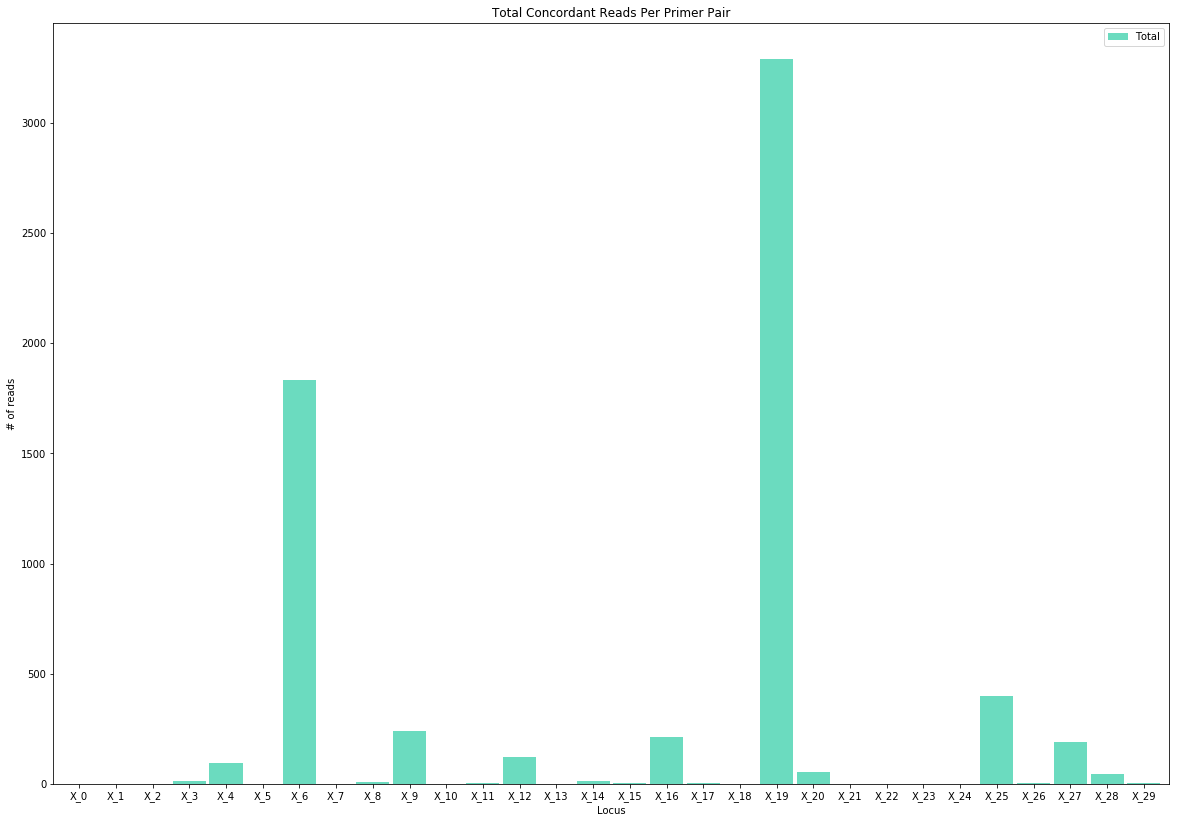

In [42]:
## Creating the first graph

%matplotlib inline

import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import matplotlib

locus_data = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/tester/1-1_S2_L001_001_locus_table.csv'

locus_df = pd.read_csv(locus_data, sep='\t')

loci = locus_df['index'].tolist()
total = locus_df['Total'].tolist()

locus_df.plot.bar(x='index', y='Total', rot=0,  figsize=(20,14), width=0.9, color = "#6bdbbf")
plt.title('Total Concordant Reads Per Primer Pair')
plt.ylabel('# of reads')
plt.xlabel('Locus')

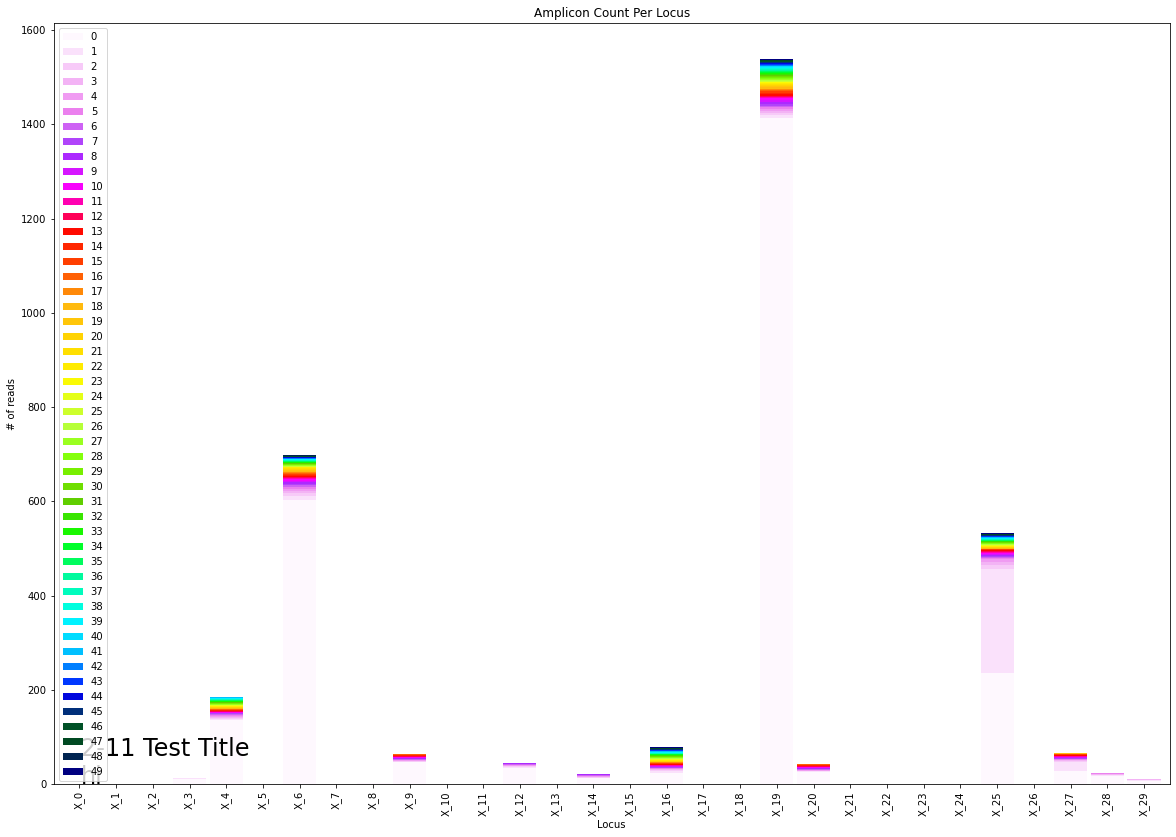

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib

locus_data = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/align/2-11_S18_L001_001_locus_table.csv'

with PdfPages('/Users/annechen/Downloads/2-11-test.pdf') as pdf:
    
    ##fig = plt.figure(figsize=(11.69,8.27))
    ##txt = '2-11 Test Title\nhi'
    ##plt.text(0.05,0.95, txt, transform=fig.transFigure, size=24)
    ##pdf.savefig()
    
    locus_df = pd.read_csv(locus_data, sep='\t')
    colors = ["#aaf0de", "#6bdbbf", '#1ec99f', '#008766']
    ## Creating second stacked bar graph

    mod_locus_df = locus_df.set_index('index')
    del mod_locus_df['Total']
    mod_locus_df = mod_locus_df.iloc[:, : 50]


    ##mod_locus_df.plot.bar(stacked=True, cmap='gnuplot', figsize=(20,14), width=0.9)
    mod_locus_df.plot.bar(stacked=True, cmap='gist_ncar_r', figsize=(20,14), width=0.9)
    txt = '2-11 Test Title\nhi'
    plt.text(0.05,0.95, txt, size=24)
    plt.title('Amplicon Count Per Locus')
    plt.ylabel('# of reads')
    plt.xlabel('Locus')
    pdf.savefig()
    
    ## Creating third stacked bar graph

    mod = locus_df.set_index('index')
    del mod['Total']
    mod = mod.iloc[:, : 50]
    mod.insert(0, 'Total', mod.sum(axis=1))
    ##colors = ["#aaf0de", "#6bdbbf", '#1ec99f', '#008766']

    for index, row in mod.iterrows():
        total = mod.loc[index,'Total']
        i=0
        while i<50:
            ##print mod.loc[index,str(i)]/total
            mod.loc[index,str(i)] = mod.loc[index,str(i)]/total
            i=i+1
            ##mod.loc[index,str(i)]

    del mod['Total']

    mod.plot.bar(stacked=True, cmap='gist_ncar_r', figsize=(20,14), width=0.9)
    plt.title('Amplicon Frequency Per Locus')
    plt.ylabel('# of reads')
    plt.xlabel('Locus')
    pdf.savefig()

    plt.close()
    
    
https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
textstr = "hello boo boo, huh?\n second line very long................odfdfelelldl   sldld \nthird line!"
mod_locus_df.plot.bar(stacked=True, cmap='gnuplot', figsize=(20,14), width=0.9)
##mod_locus_df.plot.bar(stacked=True, cmap='gist_ncar_r', figsize=(20,14), width=0.9)
plt.text(0.02, 0.9, textstr, fontsize=14, transform=plt.gcf().transFigure)
plt.title('Amplicon Count Per Locus')
plt.ylabel('# of reads')
plt.xlabel('Locus')
pdf.savefig()
plt.close()


In [155]:
%matplotlib inline

import pandas as pd
import numpy as np
from os import listdir
from Bio import SeqIO
import re
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

amplicon_data = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/align/2-11_S18_L001_001_amplicons.fasta'
locus_data = '/Users/annechen/Downloads/CRISPR_Pools_Data/results/align/2-11_S18_L001_001_locus_table.csv'
db = '/Users/annechen/PCRProject/customdb2.fasta'

amp_data = {}
db_file = {}
locus_table = {}

## Converting each data file to a format I can work with in the cell

## Converting db to dictionary with locus ID as key and value list of [primer number, sequence]
with open(db, 'rU') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        ID = str(record.id)
        m = re.search('(fwdPrimer\S+ rev\S+)',str(record.description))
        primer_info = m.group(1)
        db_file[ID] = [primer_info, str(record.seq)]

        
## Converting amplicon file to dictionary with primer freq as key and value list of [locus, sequence]
with open(amplicon_data, 'rU') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        ID = str(record.id).split('.')[0]
        m = re.search('\d+_\d+_(\S+)', ID)
        locus = m.group(1)
        freq = int(ID.split('_')[1])
        locus_info = amp_data.get(freq)
        if locus_info == None:
            amp_data[freq] = [locus, str(record.seq)]
        else:
            locus_info.append(locus)
            locus_info.append(str(record.seq))
            
## Converting locus table generated from a previous cell into manipulateable form
locus_df = pd.read_csv(locus_data, sep='\t')
del locus_df['Total']
locus_df = locus_df.set_index('index')

for index, row in locus_df.iterrows():
    freqList = []
    ##previous = 0
    for i in row:
        if i>4 and i != 'NaN':
            freqList.append(i)
            ##if i!= previous:
                ##freqList.append(i)
                ##previous = i
    locus_table[index] = freqList

##print (amp_data)
print (locus_table)
##print (db_file)

## Check if frequencies are sufficiently close to match in value; puts into a set if within range
for key in locus_table:
    primerFreq = locus_table[key]
    potential_match = set()
    i=0
    if len(primerFreq) > 0:
        while i<len(primerFreq)-1:
            ## Check if the two numbers are within 20% of each other or within 10 digits and put any potential matches into a set
            ## Set will only include highest possible numbers: if smaller pair within parameters matches, code will only print out larger set
            alignfreq1 = int(primerFreq[i])
            alignfreq2 = int(primerFreq[i+1])
            if alignfreq1 <= 1.2*alignfreq2 or alignfreq1-alignfreq2<=15:
                potential_match.add(alignfreq1)
                potential_match.add(alignfreq2)
            ## Checks if set is already filled with numbers and ends loop if another lower pair of numbers found
            else:
                if len(potential_match) != 0:
                    break
            i+=1
    ##print (str(key)+' '+str(potential_match))
            
    ## Create string output with alignments by searching through amp_data file
    dbmatch = db_file.get(key)
    message = ''
    message = 'Potential Heterozygous Amplicons: Locus '+str(key)+', '+dbmatch[0]+'\n'

    for freq in potential_match:
        amplicon_list = amp_data.get(freq)
        i=0
        while i<len(amplicon_list):
            if amplicon_list[i] == key:
                ##print (str(amplicon_list[i])+' '+str(freq))
                amplicon = amplicon_list[i+1]
                ##print ('match '+str(dbmatch))
                message+='Frequency: '+str(freq)+'\n'
                alignment = pairwise2.align.globalms(dbmatch[1], amplicon, 1, -2, -2, -2)
                ##print ('frequency: '+str(freq))
                for a in pairwise1:
                    message = message + (format_alignment(*a))
            i+=2
        print (message)
                
'''
                alignment1 = amp_data.get(alignfreq1)
                alignment2 = amp_data.get(alignfreq2)
                dbmatch = db_file.get(alignment1[0])
                                
                ##print ('Potential Pair: Locus '+alignment1[0]+', '+dbmatch[0])
                ##print ('Primer Freq: '+ str(alignfreq1))
                
                pairwise_1 = pairwise2.align.globalms(dbmatch[1],alignment1[1], 1, -2, -2, -2) 
                ##for a in pairwise1:
                    ##print (format_alignment(*a))
                    
                print ('Primer Freq: '+ str(alignfreq2))
                
                pairwise_2 = pairwise2.align.globalms(dbmatch[1],alignment2[1], 1, -2, -2, -2) 
                ##for a in pairwise_2:
                    ##print (format_alignment(*a))
                    
                ## Making into a single string format:
'''


/Users/annechen/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 'U' mode is deprecated
/Users/annechen/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 'U' mode is deprecated


{'X_0': [], 'X_1': [], 'X_2': [], 'X_3': [12.0], 'X_4': [136.0], 'X_5': [], 'X_6': [604.0, 8.0, 6.0], 'X_7': [], 'X_8': [], 'X_9': [46.0], 'X_10': [], 'X_11': [], 'X_12': [35.0], 'X_13': [], 'X_14': [13.0], 'X_15': [], 'X_16': [24.0], 'X_17': [], 'X_18': [], 'X_19': [1414.0, 5.0, 5.0], 'X_20': [26.0], 'X_21': [], 'X_22': [], 'X_23': [], 'X_24': [], 'X_25': [236.0, 221.0, 8.0, 7.0, 5.0], 'X_26': [], 'X_27': [27.0, 20.0], 'X_28': [18.0], 'X_29': [7.0]}
Potential Heterozygous Amplicons: Locus X_6, fwdPrimer=JH447 revPrimer=JH477
Frequency: 8
AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCACCGCCTTGCAAACCACACAGTGCACAAATAATTTAGCGCCGCTGCAATTATGCAGAATAGAAATGCAAAATGGAGACGTGAATGTGCGCCAATTTCACCGCTGCCGGCGGCAACCTCGGCCTCAAATCGCAAACGCCGTCGCCGAGAATCGAGCGGTTAGGCTGCTGAA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||..||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Potential Heterozygous Amplicons: Locus X_27, fwdPrimer=JH468 revPrimer=JH498
Frequency: 27
AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCACCGCCTTGCAAACCACACAGTGCACAAATAATTTAGCGCCGCTGCAATTATGCAGAATAGAAATGCAAAATGGAGACGTGAATGTGCGCCAATTTCACCGCTGCCGGCGGCAACCTCGGCCTCAAATCGCAAACGCCGTCGCCGAGAATCGAGCGGTTAGGCTGCTGAA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||..|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| |
AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCAACGCCTTGCAAGTCACACAGTGCACAAATAATTTAGCGCCGCTGCAATTATGCAGAATAGAAATGCAAAATGGAGACGTGAATGTGCGCCAATTTCACCGCTGCCGGCGGCAACCTCGGCCTCAAATCGCAAACGCCGTCGCCGAGAATCGAGCGGTTAGGCTGCTG-A
  Score=253
AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCACC

"\n                alignment1 = amp_data.get(alignfreq1)\n                alignment2 = amp_data.get(alignfreq2)\n                dbmatch = db_file.get(alignment1[0])\n                                \n                ##print ('Potential Pair: Locus '+alignment1[0]+', '+dbmatch[0])\n                ##print ('Primer Freq: '+ str(alignfreq1))\n                \n                pairwise_1 = pairwise2.align.globalms(dbmatch[1],alignment1[1], 1, -2, -2, -2) \n                ##for a in pairwise1:\n                    ##print (format_alignment(*a))\n                    \n                print ('Primer Freq: '+ str(alignfreq2))\n                \n                pairwise_2 = pairwise2.align.globalms(dbmatch[1],alignment2[1], 1, -2, -2, -2) \n                ##for a in pairwise_2:\n                    ##print (format_alignment(*a))\n                    \n                ## Making into a single string format:\n"

In [30]:
from Bio import SeqIO

db = 'PCRProject/customdb2.fasta'

db_files = {}
with open(db, 'rU') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        db_files[str(record.seq)[0:15]] = str(record.id)

print db_files
print db_files.get('CACACGCACATTCGA')

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(db_files)? (<ipython-input-30-ce875a42d20c>, line 10)

In [156]:
a = 'AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCACCGCCTTGCAAACCACACAGTGCACAAATAATTTAGCGCCGCTGCAATTATGCAGAATAGAAATGCAAAATGGAGACGTGAATGTGCGCCAATTTCACCGCTGCCGGCGGCAACCTCGGCCTCAAATCGCAAACGCCGTCGCCGAGAATCGAGCGGTTAGGCTGCTGAA'
b = 'AGAAAACGGGAGTAGCGACAGCCCTGGCGGCGCCATTGCAAAACTCACCGCACCTACGGCGCATGCAACCCTGAGTCAGTCTGGCTCCCCTCCTCACCGCCTTGCAAACCACACAGTGCACAAATAATTTAGCGCCGCTGCAATTATGCAGAATAGAAATGCAAAATGGAGACGTGAATGTGCGCCAATTTCACCGCTGCCGGCGGCAACCTCGGCCTCAAATCGCAAACGCCGTCGCCGAGAATCGAGCGGTTAGGCTGCTGAA'
print (a==b)

True
